# 2.6 Resampling Methods 

Los datos tienen una variabilidad natural, que a menudo tenemos que tener en cuenta. 

Entre otras aplicaciones (por ejemplo, la propagación de la incertidumbre o la asignación de intervalos de confianza a alguna estadística), los **métodos de remuestreo** pueden ayudarnos a explorar esta variabilidad. 

En general, el remuestreo se refiere a cualquier técnica en la que se extraen repetidamente observaciones de una muestra.
<!---
Tenga en cuenta que la siguiente afirmación es específica del remuestreo para la evaluación de modelos:
    Los métodos de remuestreo consisten en extraer repetidamente muestras de un conjunto de entrenamiento y volver a ajustar un modelo. La colección de modelos mejor ajustados proporciona confianza en el ajuste del modelo.
En términos más generales, los métodos de remuestreo se refieren a cualquier técnica en la que se extraen repetidamente observaciones de alguna muestra. Deberíamos utilizar la definición más amplia que figura en la introducción de esta sección.
--->

La lección presenta las técnicas de remuestreo de varias maneras. Exploramos varios ejemplos fundamentales de remuestreo (Nivel 1) y demostramos cómo puede utilizarse el remuestreo para la inferencia del modelo de una regresión lineal (Nivel 2).

En primer lugar, importaremos algunos módulos útiles:

In [5]:
import requests, zipfile, io, gzip, glob, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [6]:
# Definimos a generador aleatorio 
rng = np.random.default_rng()

## 1. Ejemplos de técnicas de remuestreo (Nivel 1)

### 1.1 Aleatorización

Como introdujimos en clase 

Dados dos conjuntos de datos, $A$ y $B$, y un parámetro, $x$, podemos asignar aleatoriamente observaciones a $A$ o $B$, calcular algún estadístico (por ejemplo, $x_A - x_B$), y repetir para construir una distribución de ese estadístico.

In [7]:
# Empezaremos con dos conjuntos de datos,  A y B
A = rng.normal(5, 2.5, 100)
B = rng.normal(5.5, 2.5, 100)

# Podemos calcular las medias de cada conjunto de datos 
mean_A = np.mean(A)
mean_B = np.mean(B)

print('Las medias de A y B son, ' + str(mean_A) + ' and ' + str(mean_B) + ', respectivamente.')

# Y, a título ilustrativo, calcule también la diferencia entre estas medias

diff_means = mean_A - mean_B

print('La diferencia entre las medias es, ' + str(diff_means) + '.')

Las medias de A y B son, 4.638658021000478 and 5.64899152850452, respectivamente.
La diferencia entre las medias es, -1.0103335075040416.


Ahora, querríamos remuestrear 

In [8]:
# Primero, ¿cuántas veces queremos remuestraer?
number_runs = 10000

In [9]:
# Siguiente, creamos un conjunto que pueda almacenar la diferencia de las medias
array_of_diffs = np.zeros([number_runs, 1])
# Para facilitar la carga computacional, vamos a declarar algunas variables
# Una lista combinada de A y B
combined = np.concatenate((A, B))
# Largo de A y B
length_A = len(A)

Cada vez que volvemos a muestrear, recalculamos la media y recalculamos la diferencia 

In [10]:
# Para cada ejecución:
for i in range(number_runs):
    # Barajemos la lista combinada
    # ¡Nótese que barajar funciona en su sitio!
    rng.shuffle(combined)
    # Ahora, divide la lista en A y B, manteniendo sus tamaños originales
    # ¡Fíjate en la sintaxis!
    new_A = combined[0:length_A]
    new_B = combined[length_A:len(combined)]
    # Calcular y almacenar una diferencia de medias
    array_of_diffs[i] = np.mean(new_A) - np.mean(new_B)

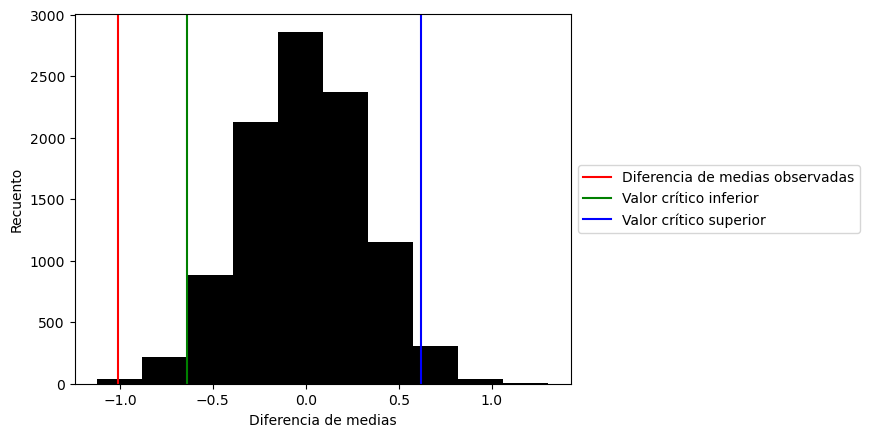

In [12]:
# Trazar la matriz de diferencias
plt.hist(array_of_diffs, color='black')

# Dado un alfa de 0,05, ¿podemos aceptar o rechazar la hipótesis nula de que no hay diferencia de medias?

alpha = 0.05
lower_critical_value = np.quantile(array_of_diffs, alpha/2)
upper_critical_value = np.quantile(array_of_diffs, 1-(alpha/2))

# Representar gráficamente los valores críticos y el valor observado
plt.axvline(x = diff_means, color='r')
plt.axvline(x = lower_critical_value, color='g')
plt.axvline(x = upper_critical_value, color='b')
plt.xlabel('Diferencia de medias')
plt.ylabel('Recuento')
plt.legend(['Diferencia de medias observadas', 'Valor crítico inferior', 'Valor crítico superior'], loc='center left', bbox_to_anchor=(1, 0.5))
# Show your plot
plt.show()

### 1.2 Bootstrapping

Al realizar bootstrapping, se extraen repetidamente observaciones, **con reemplazo**, de un conjunto de datos. Dado que está extrayendo con reemplazo, es probable que el nuevo conjunto de datos remuestreado contenga observaciones duplicadas de la muestra original.

Bootstrapping no hace grandes suposiciones sobre la distribución subyacente del conjunto de datos. 

Primero crearemos datos correlacionados utilizando la función numpy ``random.multivariate_normal`` ([docs Aquí](https://numpy.org/doc/stable/reference/random/generated/numpy.random.multivariate_normal.html)). La media de ambos datos será cero y su covarianza será -0,75.


In [13]:
# Empezamos con un conjunto de datos en el que dos variables están fuertemente correlacionadas
correlated_data= np.random.multivariate_normal([0, 0], [[1, -.75], [-.75, 1]], 1000)

En primer lugar, comprobamos que los datos están efectivamente anticorrelacionados trazando uno frente al otro

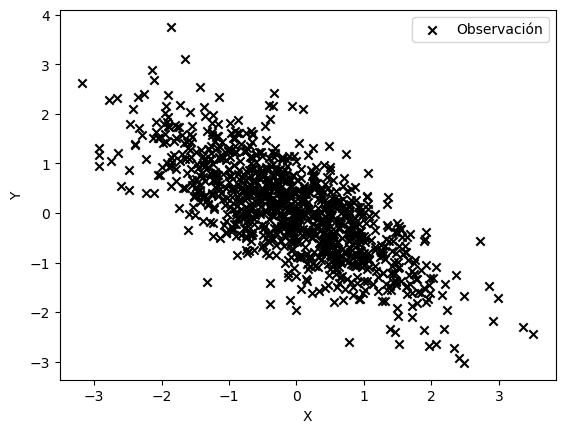

In [15]:
plt.scatter(correlated_data[:, 0], correlated_data[:, 1], marker='x', c='black')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(['Observación'])
plt.show()

Podemos verificar que el Pearson We can verify that the Pearson [coeficiente de correlación](https://en.wikipedia.org/wiki/Correlation_coefficient) se acerca a nuestro objetivo utilizando la función numpy ``corrcoef``.

In [17]:
# La matriz de correlaciones de la primera y segunda columnas de datos_correlacionados
correlation_matrix = np.corrcoef(correlated_data[:, 0], correlated_data[:, 1])

# Comprobar el coeficiente de correlación
print('El coeficiente de correlación es: ' + str(correlation_matrix[0,1]) + '.')

El coeficiente de correlación es: -0.7378367296167122.


Ahora tomamos un subconjunto de los datos --- piense en el subconjunto como una *muestra de la población verdadera*.

In [20]:
nsubset=10
subset = rng.choice(correlated_data, size=nsubset, replace=False)

Podemos calcular el coeficiente de correlación de esta muestra.

El coeficiente de correlación de nuestra muestra es: -0.700466927763732.


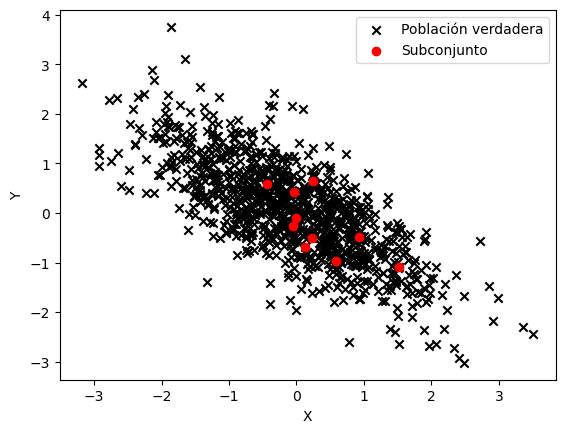

In [21]:
# Informar del coeficiente de correlación del subconjunto
print('El coeficiente de correlación de nuestra muestra es: ' + str(np.corrcoef(subset[:,0], subset[:, 1])[0,1]) + '.')

# Representar gráficamente los datos originales y nuestra muestra
plt.scatter(correlated_data[:, 0], correlated_data[:, 1], marker='x', c='black')
plt.scatter(subset[:,0], subset[:, 1], c='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(['Población verdadera', 'Subconjunto'])
plt.show()

Ahora vamos a hacer un bootstrap. Una vez más, definimos un número de ejecuciones. 

In [22]:
number_runs =1000

Cada vez que remuestreemos, calcularemos y almacenaremos el coeficiente de correlación de los datos remuestreados.

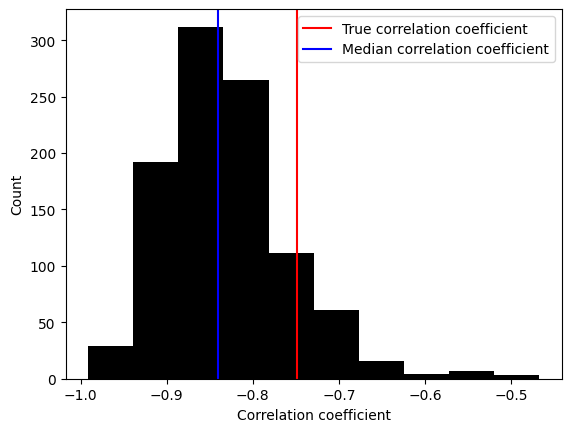

In [25]:
# Crear una matriz que mantendrá un registro de las salidas de nuestro bucle de remuestreo. En este caso, sólo queremos registrar el coeficiente de correlación de cada nueva muestra. 
corr_coef_collector = np.zeros([number_runs, 1])

# Obtengamos también la longitud del subconjunto
# Al hacer bootstrapping, ¡el tamaño del conjunto de datos remuestreado debe coincidir con el tamaño de la muestra original!
length_sub = len(subset)

# Ahora, para cada ejecución
for i in range(number_runs):
    # Queremos extraer muestras length_sub CON SUSTITUCIÓN
    new_pairs = rng.choice(subset, size=length_sub, replace=True)
    # Calcular y almacenar el coeficiente de correlación
    corr_coef_collector[i] = np.corrcoef(new_pairs[:, 0], new_pairs[:, 1])[0,1]

#Graficar los valores corr_coef_collector
plt.hist(corr_coef_collector, color='black')
plt.xlabel('Correlation coefficient')
plt.ylabel('Count')

# Mostrar el coeficiente de correlación verdadero 
plt.axvline(x=correlation_matrix[0,1], color='red')
plt.axvline(x=np.median(corr_coef_collector), color='blue')
plt.legend(['Coeficiente de correlación verdadero ', 'Mediana del coeficiente de correlación '])
plt.show()

Vemos que la mediana del coeficiente de Pearson no es exactamente el verdadero coeficiente de Pearson. ¿A qué se debe?

¿Qué ocurre si se aumenta el tamaño del subconjunto (por ejemplo, la muestra de la población verdadera)?

### 1.3 Montecarlo

Llamados así por el casino de Mónaco, los métodos de Montecarlo consisten en *simular nuevos datos* basándose en un modelo estadístico conocido (¡o supuesto!). A diferencia de los dos ejemplos anteriores, no tomamos datos de una muestra existente. 

Las técnicas de Montecarlo tienen muchas aplicaciones. Por ejemplo, los métodos de Montecarlo se utilizan para la evaluación probabilística de riesgos, la propagación de la incertidumbre en modelos y la evaluación del rendimiento de sistemas complejos. Son especialmente valiosos cuando se trata de modelos geoespaciales, medioambientales o de ingeniería complejos, en los que las relaciones entre variables no se captan fácilmente con métodos paramétricos simples.

Aquí demostramos el muestreo de Monte Carlo intentando estimar $\pi$.

Empezamos con una idea central: que el cociente entre el área de un círculo y el área de un cuadrado es $\pi/4$.

Imaginemos entonces un círculo de radio 1 inscrito en un cuadrado cuyos lados van de -1 a 1.

In [28]:
# We're going to draw a (x,y) point from a *uniform* distribution and then determine whether that point sits within the circle. If it does, we append it to two lists: points within the circle and points within the square. If not, we append it only to a list of points inside the square
in_circle = np.empty([0,2])
in_square = np.empty([0,2])

# Now, let's generate many samples
# Here, we redefine number_runs for efficiency's sake
number_runs = 50

for _ in range(number_runs): # note that _ allows to avoid creating a variable
    # Okay, get an x point and a y point
    x = rng.uniform(low=-1, high=1)
    y = rng.uniform(low=-1, high=1)
    # How far is this point from the origin?
    origin_dist = x**2 + y**2
    # If origin_dist is less than 1, then this point is inside the circle
    if origin_dist <= 1:
        in_circle = np.append(in_circle, [[x, y]], axis=0)
    in_square = np.append(in_square, [[x, y]], axis=0)

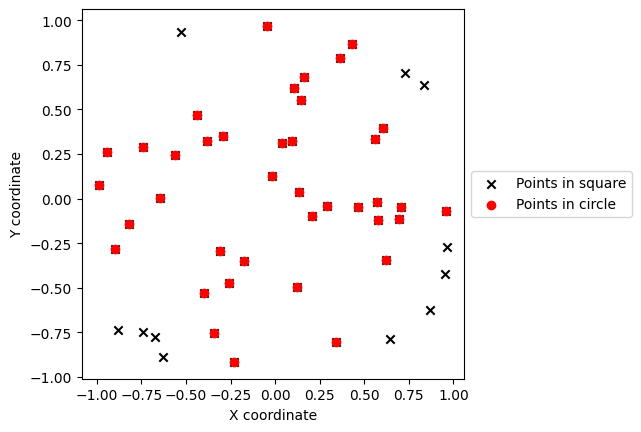

In [29]:
# We can visualize what we just did
plt.scatter(in_square[:,0], in_square[:,1], marker='x', c='black')
plt.scatter(in_circle[:,0], in_circle[:,1], marker='o', c='red')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.legend(['Points in square', 'Points in circle'], loc='center left', bbox_to_anchor=(1, 0.5))
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.show()

We now estimate $\pi$ by using the length of the number points in the circle and in the quarter as approximation to their area.

In [30]:
# Vamos a estimar pi

pi_est = 4 * (len(in_circle) / len(in_square))
              
print('We estimate the value of pi to be: ' + str(pi_est) + '.')

We estimate the value of pi to be: 3.12.


Ahora, con unas pocas ejecuciones, no obtenemos una buena respuesta. 

De hecho, un enfoque de Monte Carlo necesita más ejecuciones para **converger**. 

Debe explorar cómo cambiar el número de ejecuciones cambia su estimación de $\pi$ (y cómo converge su cálculo).

## Uso del remuestreo para la inferencia robusta de modelos (Nivel 2)

### 2.1 Movimiento de placas - Datos geodésicos

Para este tutorial, utilizaremos una serie temporal GPS en el noroeste del Pacífico y exploraremos los movimientos a largo plazo debidos a la zona de subducción de Cascadia. 

Descargaremos series temporales GPS de la Universidad de Nevada - Reno [centro de datos](!http://geodesy.unr.edu/NGLStationPages/gpsnetmap/GPSNetMap.html).


In [32]:
# The station designation
sta="P395"
file_url="http://geodesy.unr.edu/gps_timeseries/tenv/IGS14/"+ sta + ".tenv"
r = requests.get(file_url).text.splitlines()  # download, read text, split lines into a list
ue=[];un=[];uv=[];se=[];sn=[];sv=[];date=[];date_year=[];df=[]
for iday in r:  # this loops through the days of data
    crap=iday.split()
    if len(crap)<10:
      continue
    date.append((crap[1]))
    date_year.append(float(crap[2]))
    ue.append(float(crap[6])*1000)
    un.append(float(crap[7])*1000)
    uv.append(float(crap[8])*1000)
#             # errors
    se.append(float(crap[10])*1000)
    sn.append(float(crap[11])*1000)
    sv.append(float(crap[12])*1000)

In [33]:
# We now make a data frame
crap={'station':sta,'date':date,'date_year':date_year,'east':ue,'north':un,'up':uv}
if len(df)==0:
    df = pd.DataFrame(crap, columns = ['station', 'date','date_year','east','north','up'])
else:
    df=pd.concat([df,pd.DataFrame(crap, columns = ['station', 'date','date_year','east','north','up'])])
df.describe()

,date_year,east,north,up
count,6341.000000,6341.000000,6341.000000,6341.000000
mean,2014.772434,-52.534263,-30.076831,1.899511
std,5.033255,32.520022,17.516241,5.618141
min,2006.067100,-114.314000,-65.245000,-39.508000
25%,2010.409300,-80.010000,-45.813000,-1.841000
50%,2014.765200,-49.487000,-29.918000,1.720000
75%,2019.126600,-24.855000,-14.940000,5.482000
max,2023.726200,3.927000,3.157000,28.663000


Text(0.5, 0, 'Time (years)')

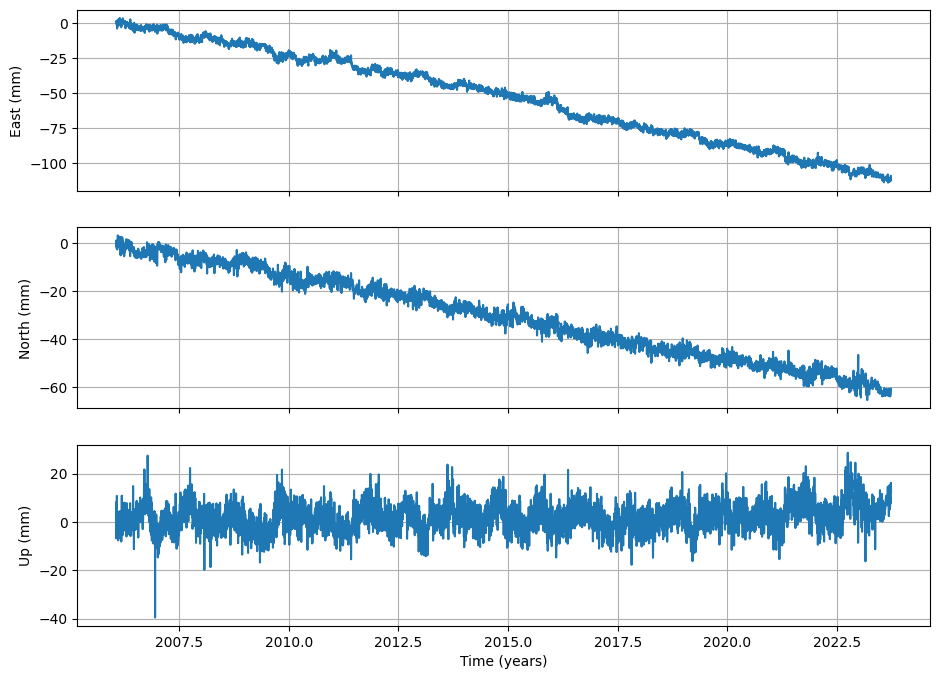

In [34]:
# Graficar las series de tiempo de GPS
fig,ax=plt.subplots(3,1,figsize=(11,8),sharex=True)
ax[0].plot(df['date_year'][df['station']==sta],df['east'][df['station']==sta]);ax[0].grid(True);ax[0].set_ylabel('East (mm)')
ax[1].plot(df['date_year'][df['station']==sta],df['north'][df['station']==sta]);ax[1].grid(True);ax[1].set_ylabel('North (mm)')
ax[2].plot(df['date_year'][df['station']==sta],df['up'][df['station']==sta]);ax[2].grid(True);ax[2].set_ylabel('Up (mm)')
ax[2].set_xlabel('Time (years)')

## 2.2 Regresión lineal

Los datos de posición horizontal muestran una clara **tendencia lineal** a lo largo de los últimos 16 años. Podemos ajustar los datos utilizando:

$E(t) = V_e t + u_e,$\
$N(t) = V_n t + u_n,$

donde $t$ es el tiempo. Queremos hacer una regresión de los datos para hallar los coeficientes $V_e$, $u_e$, $V_n$, $u_n$. Los desplazamientos son en su mayoría hacia el oeste, por lo que sólo se centrará en el Este $E(t)$ componente para este ejercicio. Los coeficientes $u_e$ y $u_n$ son la intercepción en $t=0$. No son cero en este caso porque $t$ comienza en 2006. Los coeficientes $V_e$ y $V_n$ tienen la dimensión de velocidades:

$V_e \sim E(t) / t$ , $V_n \sim N(t) / t$ ,

por lo tanto, vamos a utilizar este ejemplo para discutir un simple ** regresión lineal ** y el método de remuestreo. Utilizaremos tanto una función Scipy como una función Scikit-learn.

Para medir el rendimiento de un ajuste, mediremos lo bien que se reduce la varianza ajustando los datos (puntos de dispersión) al modelo. La varianza es:

$\text{Var}(x) = 1/n \sum_{i=1}^n (x_i-\hat{x})^2$, 

donde $\hat{x}$ es la mediana de $x$.  Al ajustar la regresión, predecimos los valores $x_{pred}$. Los residuos son las diferencias entre los datos y los valores previstos: $e = x - x_{pred} $. $R^2$ or <i> coeficiente de determinación </i> es:

$R^2 = 1 - \text{Var}(x-x_{pred}) /\text{Var}(x)  = 1 - \text{Var}(e) /\text{Var}(x) $

Cuanto menor sea el error, "mejor" será el ajuste (¡más adelante veremos que un ajuste puede ser demasiado bueno!), más se acercará $R^2$ a uno.

In [56]:
# now let's find the trends and detrend the data.
from scipy import stats
# linear regression such that: displacement = Velocity * time
# velocity in the East component.
Ve, intercept, r_value, p_value, std_err = stats.linregress(df['date_year'][df['station']==sta],df['east'][df['station']==sta])
# horizontal plate motion:
print(sta,"overall plate motion there",Ve,'mm/year')
print("parameters: Coefficient of determination %f4.2, P-value %f4.2, standard deviation of errors %f4.2"\
      %(r_value,p_value,std_err))


P395 overall plate motion there -6.438107857588663 mm/year
parameters: Coefficient of determination -0.9964524.2, P-value 0.0000004.2, standard deviation of errors 0.0068304.2


Podemos también usar el paquete``scikit-learn``:

Coefficient / Velocity eastward (mm/year):  -6.438107857588658


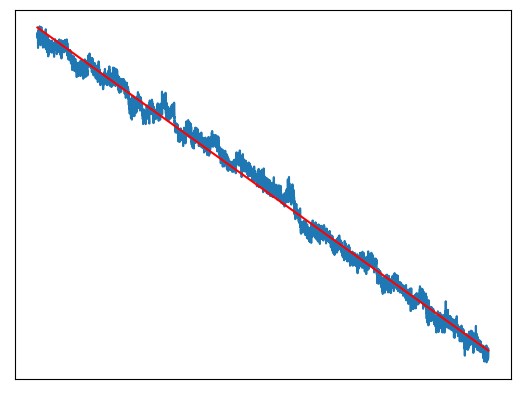

In [57]:
from sklearn.linear_model import LinearRegression
# convert the data into numpy arrays.
E = np.asarray(df['east'][df['station']==sta]).reshape(-1, 1)# reshaping was necessary to be an argument of Linear regress
t = np.asarray(df['date_year'][df['station']==sta]).reshape(-1, 1)
tt = np.linspace(np.min(t),np.max(t),1000)

# perform the linear regression. First we will use the entire available data
regr = LinearRegression()
# we will first perform the fit:
regr.fit(t,E)
# We will first predict the fit:
Epred=regr.predict(t) 

# The coefficients
print('Coefficient / Velocity eastward (mm/year): ', regr.coef_[0][0])

plt.plot(t,E);ax[0].grid(True);ax[0].set_ylabel('East (mm)')
plt.plot(t,Epred,color="red")
plt.grid(True)
plt.xticks(())
plt.yticks(())
plt.show()


To evaluate the errors of the model fit using the module ``sklearn``, we will use the following function

In [58]:
from sklearn.metrics import mean_squared_error, r2_score
# The mean squared error
print('Mean squared error (mm): %.2f'
      % mean_squared_error(E, Epred))
# The coefficient of determination: 1 is the perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(E, Epred))

Mean squared error (mm): 7.49
Coefficient of determination: 0.99


### 2.3 Bootstrapping


Now we will use again bootstrapping to estimate the slope of the regression over many resampled data.


Scikit-learn seems to have deprecated the bootstrap function, but we can find ``resample`` in the ``utils`` module. Make sure you use ``replace=True``.
For reproducible results, you can select a fixed ``random_state=int`` to be kept in the workflow. Usually bootstrapping is done over many times (unlike K-fold cross validation).

mean of the velocity estimates -6.4382164.2 and the standard deviation 0.0060364.2


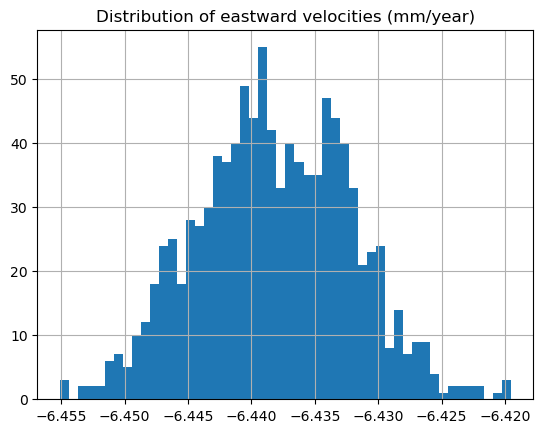

In [59]:
from sklearn.utils import resample
k=1000
vel = np.zeros(k) # initalize a vector to store the regression values
mse = np.zeros(k)
r2s = np.zeros(k)
i=0
for iik in range(k):    
    ii = resample(np.arange(len(E)),replace=True,n_samples=len(E))# new indices
    E_b, t_b = E[ii], t[ii]
    # now fit the data on the training set.
    regr = LinearRegression()
    # Fit on training data:
    regr.fit(t_b,E_b)
    Epred_val=regr.predict(t) # test on the validation set.

    # The coefficients
    vel[i]= regr.coef_[0][0]
    i+=1

# the data shows clearly a trend, so the predictions of the trends are close to each other:
print("mean of the velocity estimates %f4.2 and the standard deviation %f4.2"%(np.mean(vel),np.std(vel)))

plt.hist(vel,50);plt.title('Distribution of eastward velocities (mm/year)');plt.grid(True)
plt.show()


### 2.4 Cross validation
x

Cross-validation is a widely used technique in machine learning to assess the **performance** and **generalization** of a model. It involves partitioning the dataset into multiple subsets, training the model on a portion of the data, and then evaluating its performance on the remaining data. This process is repeated several times, and *the results are averaged* to obtain a more reliable estimate of the model's performance. The primary goal is *to mitigate the risk of overfitting and obtain a more robust evaluation metric*.

There are several tutorials on [cross-validation](!https://scikit-learn.org/stable/modules/cross_validation.html).

Cross-validation divides the data set between a *training* set and a *validation* set:

<div>
<img src="ValsetApproach.png" width="500"/>
</div>
From: scikit-learn: concept for training and validation set.

Often the validation set ends up underestimating the prediction errors (model uncertainties) because the validation set is often smaller than the training set. To alleviate that, we can perform cross-validation over many folds of selecting a validation and training set.
<div>
<img src="grid_search_cross_validation.png" width="500"/>
</div>
From: scikit-learn


* **División de datos**: La validación cruzada consiste en *dividir un conjunto de datos en varios subconjuntos*, normalmente un conjunto de entrenamiento y un conjunto de pruebas. Esta división permite evaluar y validar el modelo.

* **Estimación: La validación cruzada se utiliza principalmente para *evaluar el rendimiento predictivo* de modelos de aprendizaje automático o modelos estadísticos. Ayuda a estimar lo bien que un modelo se generalizará a datos nuevos, no vistos, probando su rendimiento en datos que no se utilizaron en el entrenamiento.

* **Datos correlacionados**: La validación cruzada no aborda explícitamente los datos correlacionados, y su eficacia puede verse influida por la estrategia de división de los datos. Cuando los datos muestran fuertes correlaciones, es esencial diseñar cuidadosamente el procedimiento de validación cruzada para garantizar que todos los subconjuntos representan la distribución general de los datos.

**Aplicaciones**: La validación cruzada se emplea ampliamente en *selección de modelos*, *ajuste de hiperparámetros* y *evaluación de la capacidad de generalización* de los modelos. 

Ahora seleccionaremos aleatoriamente un conjunto de entrenamiento y validación utilizando el módulo ``sklearn``:

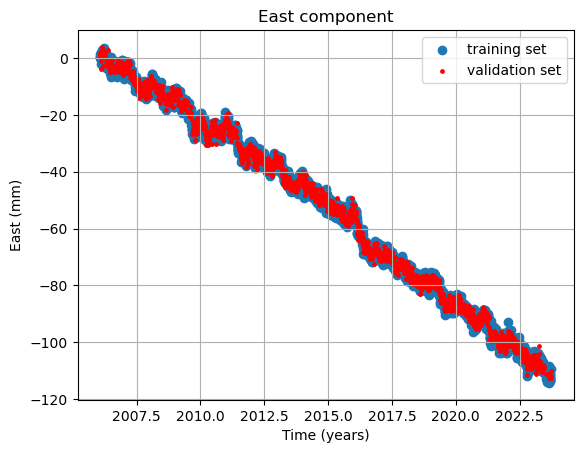

In [60]:
# we randomly select values and split the data between training and validation set.
from sklearn.model_selection import ShuffleSplit
# we split once the data between a training and a validating set 
n=1 # we do this selection once
v_size = 0.3 # 30% of the data will be randomly selected to be the validation set.

rs = ShuffleSplit(n_splits=n, test_size=.3, random_state=0)
for train_index, val_index in rs.split(E):
    E_train, E_val = E[train_index], E[val_index]
    t_train, t_val = t[train_index], t[val_index]
plt.scatter(t_train,E_train,marker="o");plt.grid(True);plt.ylabel('East (mm)')
plt.scatter(t_val,E_val,marker="o",s=6,c="red")
plt.xlabel('Time (years)')
plt.title('East component')
plt.legend(['training set','validation set'])

Ahora ajustamos los datos y evaluamos el error

Training set: Coefficient / Velocity eastward (mm/year):  -6.442660214306567
MSE (mean square error) on training set (mm): 7.32
Coefficient of determination on training set: 0.99
MSE on validation set (mm): 7.88 and coefficient of determiniation on 0.99


Text(0.5, 1.0, 'Random selection for data split')

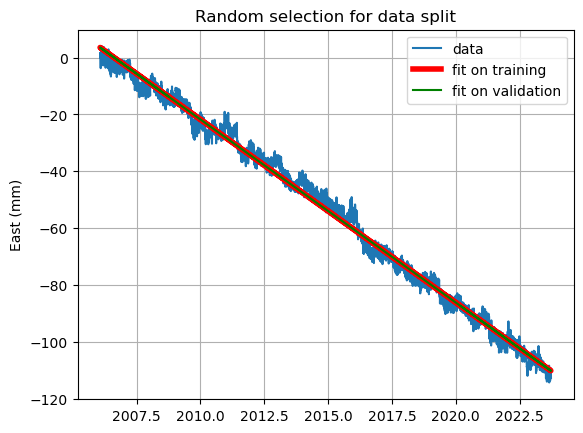

In [61]:
# Ahora ajustamos los datos con el conjunto de entrenamiento.
regr = LinearRegression()
# Fit on training data:
regr.fit(t_train,E_train)
# We will first predict the fit:
Epred=regr.predict(t_train) 
Epred_val=regr.predict(t_val) 

# The coefficients
print('Training set: Coefficient / Velocity eastward (mm/year): ', regr.coef_[0][0])

print('MSE (mean square error) on training set (mm): %.2f'
      % mean_squared_error(Epred, E_train))
# The coefficient of determination: 1 is the perfect prediction
print('Coefficient of determination on training set: %.2f'
      % r2_score(Epred, E_train))

print('MSE on validation set (mm): %.2f and coefficient of determiniation on %.2f' %(mean_squared_error(Epred_val, E_val), r2_score(Epred_val, E_val)))


plt.plot(t,E);plt.grid(True);plt.ylabel('East (mm)')
plt.plot(t_train,Epred,color="red",linewidth=4)
plt.plot(t_val,Epred_val,color="green")
plt.legend(['data','fit on training','fit on validation'])
plt.title('Random selection for data split')


También podemos seleccionar que el entrenamiento y la validación sean cronológicos. Si el "estado" de los datos cambia con el tiempo, esto puede inducir un sesgo en el entrenamiento. Pero veamos.

 Training set: Coefficient / Velocity eastward (mm/year):  -6.147744826538707
Validation set MSE (mm) and Coef of Determination: 17.72,0.85


Text(0.5, 1.0, 'Chronological selection for data split')

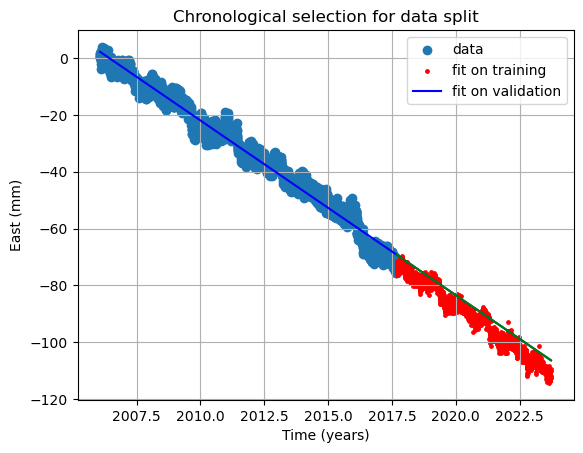

In [62]:
E_train, E_val = E[:2*len(E)//3], E[2*len(E)//3+1:]
t_train, t_val = t[:2*len(E)//3], t[2*len(E)//3+1:]
plt.scatter(t_train,E_train,marker="o");plt.grid(True);plt.ylabel('East (mm)')
plt.scatter(t_val,E_val,marker="o",s=6,c="red")
plt.xlabel('Time (years)')
plt.title('East component')
plt.legend(['training set','validation set'])

# now fit the data on the training set.
regr = LinearRegression()
# Fit on training data:
regr.fit(t_train,E_train)
# We will first predict the fit:
Epred=regr.predict(t) 
Epred_val=regr.predict(t_val) 

# Los coeficientes
print(' Conjunto entrenado: Coeficiente / Velocidad al este(mm/year): ', regr.coef_[0][0])

print('Conjunto de validación MSE (mm) y coeficiente de determinación: %.2f,%.2f' 
%(mean_squared_error(E_val, Epred_val),r2_score(E_val, Epred_val)))


plt.plot(t,Epred,color="blue")
plt.plot(t_val,Epred_val,color="green")
plt.legend(['datos','ajuste del entrenamiento','ajuste de validación'])
plt.title('Selección cronológica para la división de datos')


Ahora se ve que la elección de los datos de _entrenamiento_ frente a los de _validación_ es importante para ajustar un modelo que generalice. 

### 2.5 Leave One Out Cross Validation

LOOCV  divide los datos en 2 conjuntos (entrenamiento y validación)  <i>n</i> times (<i>n</i> es el número de puntos de datos). En cada repetición, el conjunto de entrenamiento son **todos los datos menos uno**, el conjunto de validación es un elemento.
<div>
<img src="LOOCV.png" width="500"/>
</div>
Ventajas: tiene mucho menos sesgo con respecto a los datos de entrenamiento. No sobrestima el error de prueba. La repetición de LOOCV dará exactamente los mismos resultados.

Desventajas: es computacionalmente intensivo.

* **División de datos**: LOOCV es una forma extrema de validación cruzada en la que, para cada iteración, sólo se deja fuera un punto de datos como conjunto de prueba, y los datos restantes se utilizan como conjunto de entrenamiento. Este proceso se repite para cada punto de datos, creando tantos pliegues como puntos de datos.

* **Estimación**: LOOCV se utiliza principalmente para evaluar el rendimiento del modelo y estimar la precisión predictiva. Al evaluar el modelo frente a todos los puntos de datos de uno en uno, LOOCV proporciona una evaluación sólida de la capacidad de un modelo para generalizar a datos no vistos.

* **Datos correlacionados**: LOOCV, al igual que otros métodos de validación cruzada, puede no tener en cuenta explícitamente los datos correlacionados. Sin embargo, su rendimiento puede verse influido por la estructura de correlación de los datos. Para conjuntos de datos con fuertes correlaciones, LOOCV puede conducir a modelos demasiado optimistas, ya que a menudo prueba un modelo en puntos de datos que están estrechamente relacionados con el conjunto de entrenamiento.

* Aplicaciones LOOCV es valioso para evaluar el aprendizaje automático y los modelos estadísticos, especialmente cuando se dispone de una cantidad limitada de datos.

In [19]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()

vel = np.zeros(len(E)) # initalize a vector to store the regression values
mse_train = np.zeros(len(E))
mse_val = np.zeros(len(E))
r2s = np.zeros(len(E))
i=0
for train_index, test_index in loo.split(E):    
    E_train, E_val = E[train_index], E[val_index]
    t_train, t_val = t[train_index], t[val_index]
    # now fit the data on the training set.
    regr = LinearRegression()
    # Fit on training data:
    regr.fit(t_train,E_train)
    # We will first predict the fit:
    Epred_train=regr.predict(t_train) 
    Epred_val=regr.predict(t_val) 

    # The coefficients
    vel[i]= regr.coef_[0][0]
    mse_train[i]= mean_squared_error(E_train, Epred_train)
    mse_val[i]= mean_squared_error(E_val, Epred_val)
    r2s[i]=r2_score(E_val, Epred_val)
    i+=1

# the data shows clearly a trend, so the predictions of the trends are close to each other:
print("mean of the velocity estimates %f4.2 and the standard deviation %f4.2"%(np.mean(vel),np.std(vel)))
# the test error is the average of the mean-square-errors
print("CV = %4.2f"%(np.mean(mse_val)))

mean of the velocity estimates -6.4381084.2 and the standard deviation 0.0000794.2
CV = 7.87


LOOCV is rarely used in practice. This example is just to show the extreme end member of cross-fold validation.

### 2.6 K-fold cross validation

Designed to reduce the computational cost of LOOCV. Randomly devide over <i>k</i> groups/folds of approximately equal size. It is typical to use <i>5</i> or <i>10</i>.

<div>
<img src="Kfold.png" width="500"/>
</div>

In [20]:
from sklearn.model_selection import KFold

# let's try on 10-folds, 10 adjacent split of the data.
k=10
kf = KFold(n_splits=k)

vel = np.zeros(k) # initalize a vector to store the regression values
mse_train = np.zeros(k)
mse_val = np.zeros(k)
r2s = np.zeros(k)
i=0
for train_index, val_index in kf.split(E):    
    E_train, E_val = E[train_index], E[val_index]
    t_train, t_val = t[train_index], t[val_index]
    # now fit the data on the training set.
    regr = LinearRegression()
    # Fit on training data:
    regr.fit(t_train,E_train)
    # We will first predict the fit:
    Epred_train=regr.predict(t_train) 
    Epred_val=regr.predict(t_val) 

    # The coefficients
    vel[i]= regr.coef_[0][0]
    mse_val[i]= mean_squared_error(E_val, Epred_val)
    mse_train[i]= mean_squared_error(E_train, Epred_train)
    r2s[i]=r2_score(E_train, Epred_train)
    i+=1

# the data shows clearly a trend, so the predictions of the trends are close to each other:
print("mean of the velocity estimates %4.2f and the standard deviation %4.2f"%(np.mean(vel),np.std(vel)))
# the test error is the average of the mean-square-errors
print("mean MSE for training set : %4.2f and the validation set: %4.2f"%(np.mean(mse_train),np.mean(mse_val)))

mean of the velocity estimates -6.44 and the standard deviation 0.04
mean MSE for training set : 7.43 and the validation set: 8.78
